# Class 19: Hypothesis tests continued

Plan for today:
- Hypothesis tests for assessing causality (comparing two proportions)
- Hypothesis tests for comparing two means
- Hypothesis tests for correlation
- Two-sided hypothesis tests


In [41]:
import YData

# YData.download.download_class_code(19)   # get class code    
# YData.download.download_class_code(19, TRUE) # get the code with the answers 

# YData.download.download_class_file('project_template.ipynb', 'homework')  # downloads the class project template 
# YData.download_homework(8)  # downloads the 8th homework 

YData.download_data("bta.csv")
YData.download_data("babies.csv")
YData.download_data("amazon.csv")

The file `bta.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.
The file `babies.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.
The file `amazon.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.


If you are using colabs, you should run the code below.

In [42]:
# !pip install https://github.com/emeyers/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


## 1. Hypothesis test for two proportions

In hypothesis testing, we start with a claim about a population parameter (e.g., µ = 4.2, or π = 0.25).

This claim implies we should get a certain distribution of statistics, called "The null distribution". 

If our observed statistic is highly unlikely to come from the null distribution, we reject the claim. 

We can break down the process of running a hypothesis test into 5 steps. 

1. State the null and alternative hypothesis
2. Calculate the observed statistic of interest
3. Create the null distribution 
4. Calculate the p-value 
5. Make a decision

Let's run through these steps now by doing one more practice problem running a hypothesis test for a single proportion!


### Step 1: State the null and alternative hypotheses


$H_0$: $\pi_{treat} =  \pi_{control}$   or    $H_0$: $\pi_{treat} -  \pi_{control} = 0$ 

$H_A$: $\pi_{control} < \pi_{treat}$    or    $H_0$: $\pi_{treat} -  \pi_{control} < 0$ 



Where $\pi_{treat}$ and $\pi_{control}$ and the population proportions of people who experienced back pain relief after receiving the BTA or control respectively. 


### Step 2: Calculate the observed statistic

The code below loads the data from the study. We can use the difference in proportions  $\hat{p}_{treat} - \hat{p}_{control}$  as our observed statistic. 

Let's calculate the observe statistic and save it to the name `obs_stat`.


In [44]:
bta = pd.read_csv('bta.csv')
bta.sample(frac = 1)

,Group,Result
29,Treatment,0.0
30,Treatment,0.0
11,Control,0.0
27,Treatment,0.0
28,Treatment,0.0
21,Treatment,1.0
18,Treatment,1.0
4,Control,0.0
15,Control,0.0
7,Control,0.0


In [45]:
# create a DataFrame with the proportion of people in the treatment and control groups that have pain relief 

results_table = bta.groupby("Group").mean()

results_table

,Result
Group,
Control,0.125
Treatment,0.600


In [46]:
# calculate the difference
obs_stat_series = results_table.loc["Treatment"] - results_table.loc["Control"]

# extract the value from a series to 
obs_stat = obs_stat_series.iloc[0]

obs_stat

0.475

In [47]:
# let's write a function to make it easy to get statistic values

def get_prop_diff(bta_data):
    
    group_means = bta_data.groupby("Group").mean()
    
    the_difference = group_means.loc["Treatment"] - group_means.loc["Control"]
    
    return the_difference.iloc[0]


# Try the function out
get_prop_diff(bta)


0.475

### Step 3: Create the null distribution 

To create the null distribution, we need to create statistics consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the treatment and control group. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [48]:
# shuffle the data 

shuff_bta = bta.copy()
shuff_bta['Group'] = np.random.permutation(bta["Group"])

shuff_bta.head()


,Group,Result
0,Treatment,1.0
1,Control,1.0
2,Treatment,0.0
3,Control,0.0
4,Control,0.0


In [49]:
# get one statistic consistent with the null distribution 

get_prop_diff(shuff_bta)

0.21666666666666667

In [50]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):
    
    shuff_bta['Group'] = np.random.permutation(bta["Group"])
    
    shuff_stat = get_prop_diff(shuff_bta)
    
    null_dist.append(shuff_stat)


CPU times: user 7.71 s, sys: 109 ms, total: 7.82 s
Wall time: 8.68 s


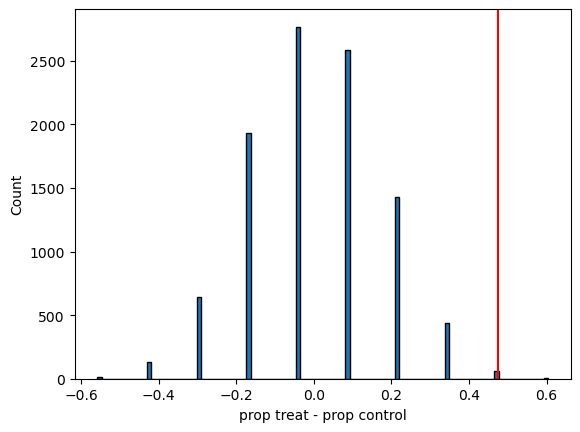

In [51]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("prop treat - prop control");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [52]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0064

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis. Because the participants were **randomly assigned to the treatment and control groups**, we canconclude that BTA does **cause** pain relief at a higher rate than the placebo. 

<br>
<center>
<img src="https://image.spreadshirtmedia.com/image-server/v1/compositions/T347A2PA4306PT17X24Y42D1035176833W20392H24471/views/1,width=550,height=550,appearanceId=2,backgroundColor=000000,noPt=true/ok-but-first-botox-fillers-botox-funny-botox-womens-t-shirt.jpg" alt="botox" style="width: 200px;"/>
</center>
<br>

## 2. Hypothesis test for two means: Smoking and baby weights

The Child Health and Development Studies investigate a range of topics. One study, in particular, considered all pregnancies between 1960 and 1967 among women in the Kaiser Foundation Health Plan in the San Francisco East Bay area.

Let's examine this data to see if the average weight of babies of babies is different depending on whether the mother of the baby smokes. 


### Step 1: State the null and alternative hypotheses


$H_0$: $\mu_{non-smoke} =  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} = 0$ 

$H_A$: $\mu_{non-smoke} >  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} > 0$ 


Where $\mu_{non-smoke}$ and $\mu_{smoke}$ are the population means of babies born to mothers who did not smoke and who smoked.

### Step 2: Calculate the observed statistic

The code below loads the data from the study. The two relevant columns are:
- `bwt`: The birth weight of the baby in ounces
- `smokes`: whether the mother smokes (1) or does not smoke (0)

More information about the data is available at: https://www.openintro.org/data/index.php?data=babies

In [53]:
babies = pd.read_csv("babies.csv")

babies.head()

,case,bwt,gestation,parity,age,height,weight,smoke
0,1,120,284.0,0,27.0,62.0,100.0,0.0
1,2,113,282.0,0,33.0,64.0,135.0,0.0
2,3,128,279.0,0,28.0,64.0,115.0,1.0
3,4,123,NaN,0,36.0,69.0,190.0,0.0
4,5,108,282.0,0,23.0,67.0,125.0,1.0


To simplify the analysis, create a new DataFrame called `babies2` that only has the smoke and bwt columns. 

In [54]:
# create a DataFrame called babies2 that has only the smoke and bwt columns
babies2 = babies[["smoke", "bwt"]]
babies2.head(3)

,smoke,bwt
0,0.0,120
1,0.0,113
2,1.0,128


Let's have our observed statistic be the different of sample means  $\bar{x}_{non-smoke} - \bar{x}_{smoke}$.  

Please calculate this observe statistic and save it to the name `obs_stat`.


In [55]:
results_table = babies2.groupby("smoke").mean()
results_table

,bwt
smoke,
0.0,123.047170
1.0,114.109504


In [56]:

obs_stat_series = results_table.iloc[0] - results_table.iloc[1]

obs_stat = obs_stat_series.iloc[0]

obs_stat

8.93766567908935

To make the rest of the analysis easier, write a function `get_diff_baby_weights(babies_df)` that will take a DataFrame `babies_df` that has smoke and btw information will return the difference in the means of babies that have mothers who to not smoke and those who do smoke. 

Also, test the function to make sure it give the same observed statistic you calculated above

In [57]:
def get_diff_baby_weights(babies_df):
    
    results_table = babies_df.groupby("smoke").mean()
    obs_stat_series = results_table.iloc[0] - results_table.iloc[1]
    return obs_stat_series.iloc[0]


# get that the function works

get_diff_baby_weights(babies2)


8.93766567908935

### Step 3: Create the null distribution 

Now let's create a null distribution that has 10,000 statistics that are consistent with the null hypothesis. 

In this example, if the null hypothesis was true, then there would be no difference between the smoking mothers and the non-smoking mothers. Thus, under the null hypothesis, we can shuffle the group labels and get equally valid statistics. 

Let's create one statistic consistent with the null distribution to understand the process. We can then repeat this 10,000 times to get a full null distribution. 

In [58]:
# shuffle the data 

shuff_babies = babies2.copy()
shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])

get_diff_baby_weights(shuff_babies)


-0.4188088926510858

In [59]:
%%time

# create a full null distribution 

null_dist = []

for i in range(10000):  
    
    shuff_babies['smoke'] = np.random.permutation(shuff_babies["smoke"])
    
    shuff_stat = get_diff_baby_weights(shuff_babies)
    
    null_dist.append(shuff_stat)


CPU times: user 8.69 s, sys: 168 ms, total: 8.86 s
Wall time: 10.5 s


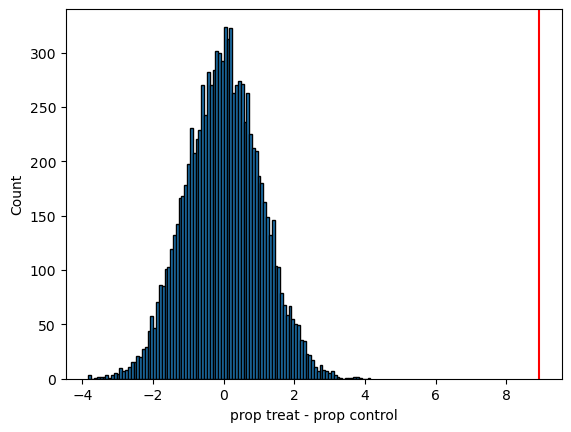

In [60]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("prop treat - prop control");
plt.ylabel("Count");

### Step 4: Calculate the p-value

The p-value is the proportion of points in the null distribution that are more extreme than the observed statistic. 


In [61]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0

### Step 5: Draw a conclusion

Since the p-value is less than the typical significance level of 0.05, we can reject the null hypothesis. This we conclude there is a difference between in the average weight of babies born to mothers who smoke compared to mothers who do not smoke. 

However, because this was an observational study, where mothers were **not** randomly assigned to treatment and control groups, we can conclude that smoking does causes babies to have less weight when they are born. In particular, it is possible there could be other "lurking/confounding" variables that cause both the mothers to smoke, and the babies to have less weight. 

<br>
<center>
<img src="https://i.ytimg.com/vi/x4c_wI6kQyE/maxresdefault.jpg" alt="smoking" style="width: 300px;"/>
</center>
<br>

## 3. Hypothesis tests for correlation

Let's run a hypothesis tests for correlation to see if books that have more pages cost more! 


### Step 1: State the null and alternative hypotheses

**In words** 

Null hypthesis: There is no correlation between the number of pages in a book and the cost of the book. 

Alternative hypothesis: Books that have more pages cost more. 

**In symbols**

$H_0$: $\rho = 0$  

$H_A$: $\rho > 0$  


### Step 2: Calculate the observed statistic

Data on 230 books from Amazon.com are loaded below. Let's calculate the observed correlation ($r$) between the number of pages in the book (`NumPages`) and the listed price (`List.Price`). 

To make your life easier, first just reduce the data set to only the `NumPages` and `List.Price` columns and save this to a DataFrame called `amazon_smaller`. Then use `amazon_smaller` for the rest of this problem


In [62]:
amazon = pd.read_csv("amazon.csv")

amazon.head(3)

,Title,Author,List.Price,Amazon.Price,Hard..Paper,NumPages,Publisher,Pub.year,ISBN.10,Height,Width,Thick,Weight..oz.
0,"1,001 Facts that Will Scare the S#*t Out of Yo...",Cary McNeal,12.95,5.18,P,304,Adams Media,2010.0,1605506249,7.8,5.5,0.8,11.2
1,21: Bringing Down the House - Movie Tie-In: Th...,Ben Mezrich,15.00,10.20,P,273,Free Press,2008.0,1416564195,8.4,5.5,0.7,7.2
2,100 Best-Loved Poems (Dover Thrift Editions),Smith,1.50,1.50,P,96,Dover Publications,1995.0,486285537,8.3,5.2,0.3,4.0


In [63]:
import statistics

amazon_smaller = amazon[["NumPages", "List.Price"]]

obs_stat = statistics.correlation(amazon_smaller.NumPages, amazon_smaller["List.Price"])

obs_stat

0.21455197256312525

### Step 3: Create the null distribution 

How can we create one statistic consistent with the null hypothesis? 

See if you can create one statistic consistent with the null distribution below. Once you have done that, create the full null distribution!



In [64]:
# Create one statistic consistent with the null distribution
statistics.correlation(amazon_smaller.NumPages, np.random.permutation(amazon_smaller["List.Price"]))


-0.12349493766817668

In [65]:
%%time

# Create the full null distribution

null_dist = []

for i in range(10000):  
        
    shuff_stat = statistics.correlation(amazon_smaller.NumPages, 
                                        np.random.permutation(amazon_smaller["List.Price"]))
    
    null_dist.append(shuff_stat)



CPU times: user 2.75 s, sys: 34.1 ms, total: 2.78 s
Wall time: 2.93 s


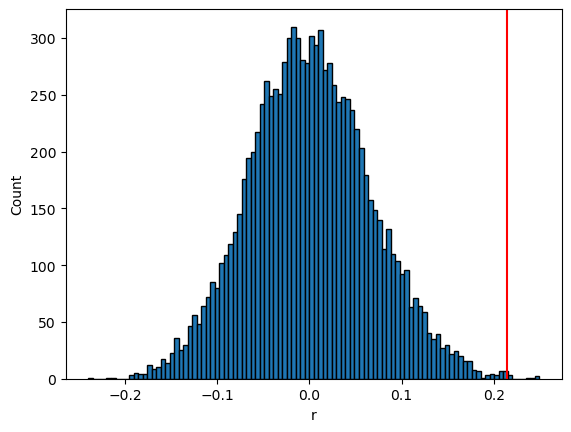

In [66]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("r");
plt.ylabel("Count");

### Step 4: Calculate the p-value


In [67]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0008

### Step 5: Draw a conclusion

The p-value is small (less than the convensional level of 0.05) so we would reject the null hypothesis and conclude that there is a correlation between the number of pages in a book and the price of a book at the population level. 


## 4. Visualizing hypothesis tests for correlation

We can also run a visual hypothesis test for correlation by creating a visual lineup that displays several scatter plots of shuffled data and one scatter plot of the real data. If you can tell which plot contains the real (unshuffled) data, this corresponds to being able to reject the null hypothesis. 


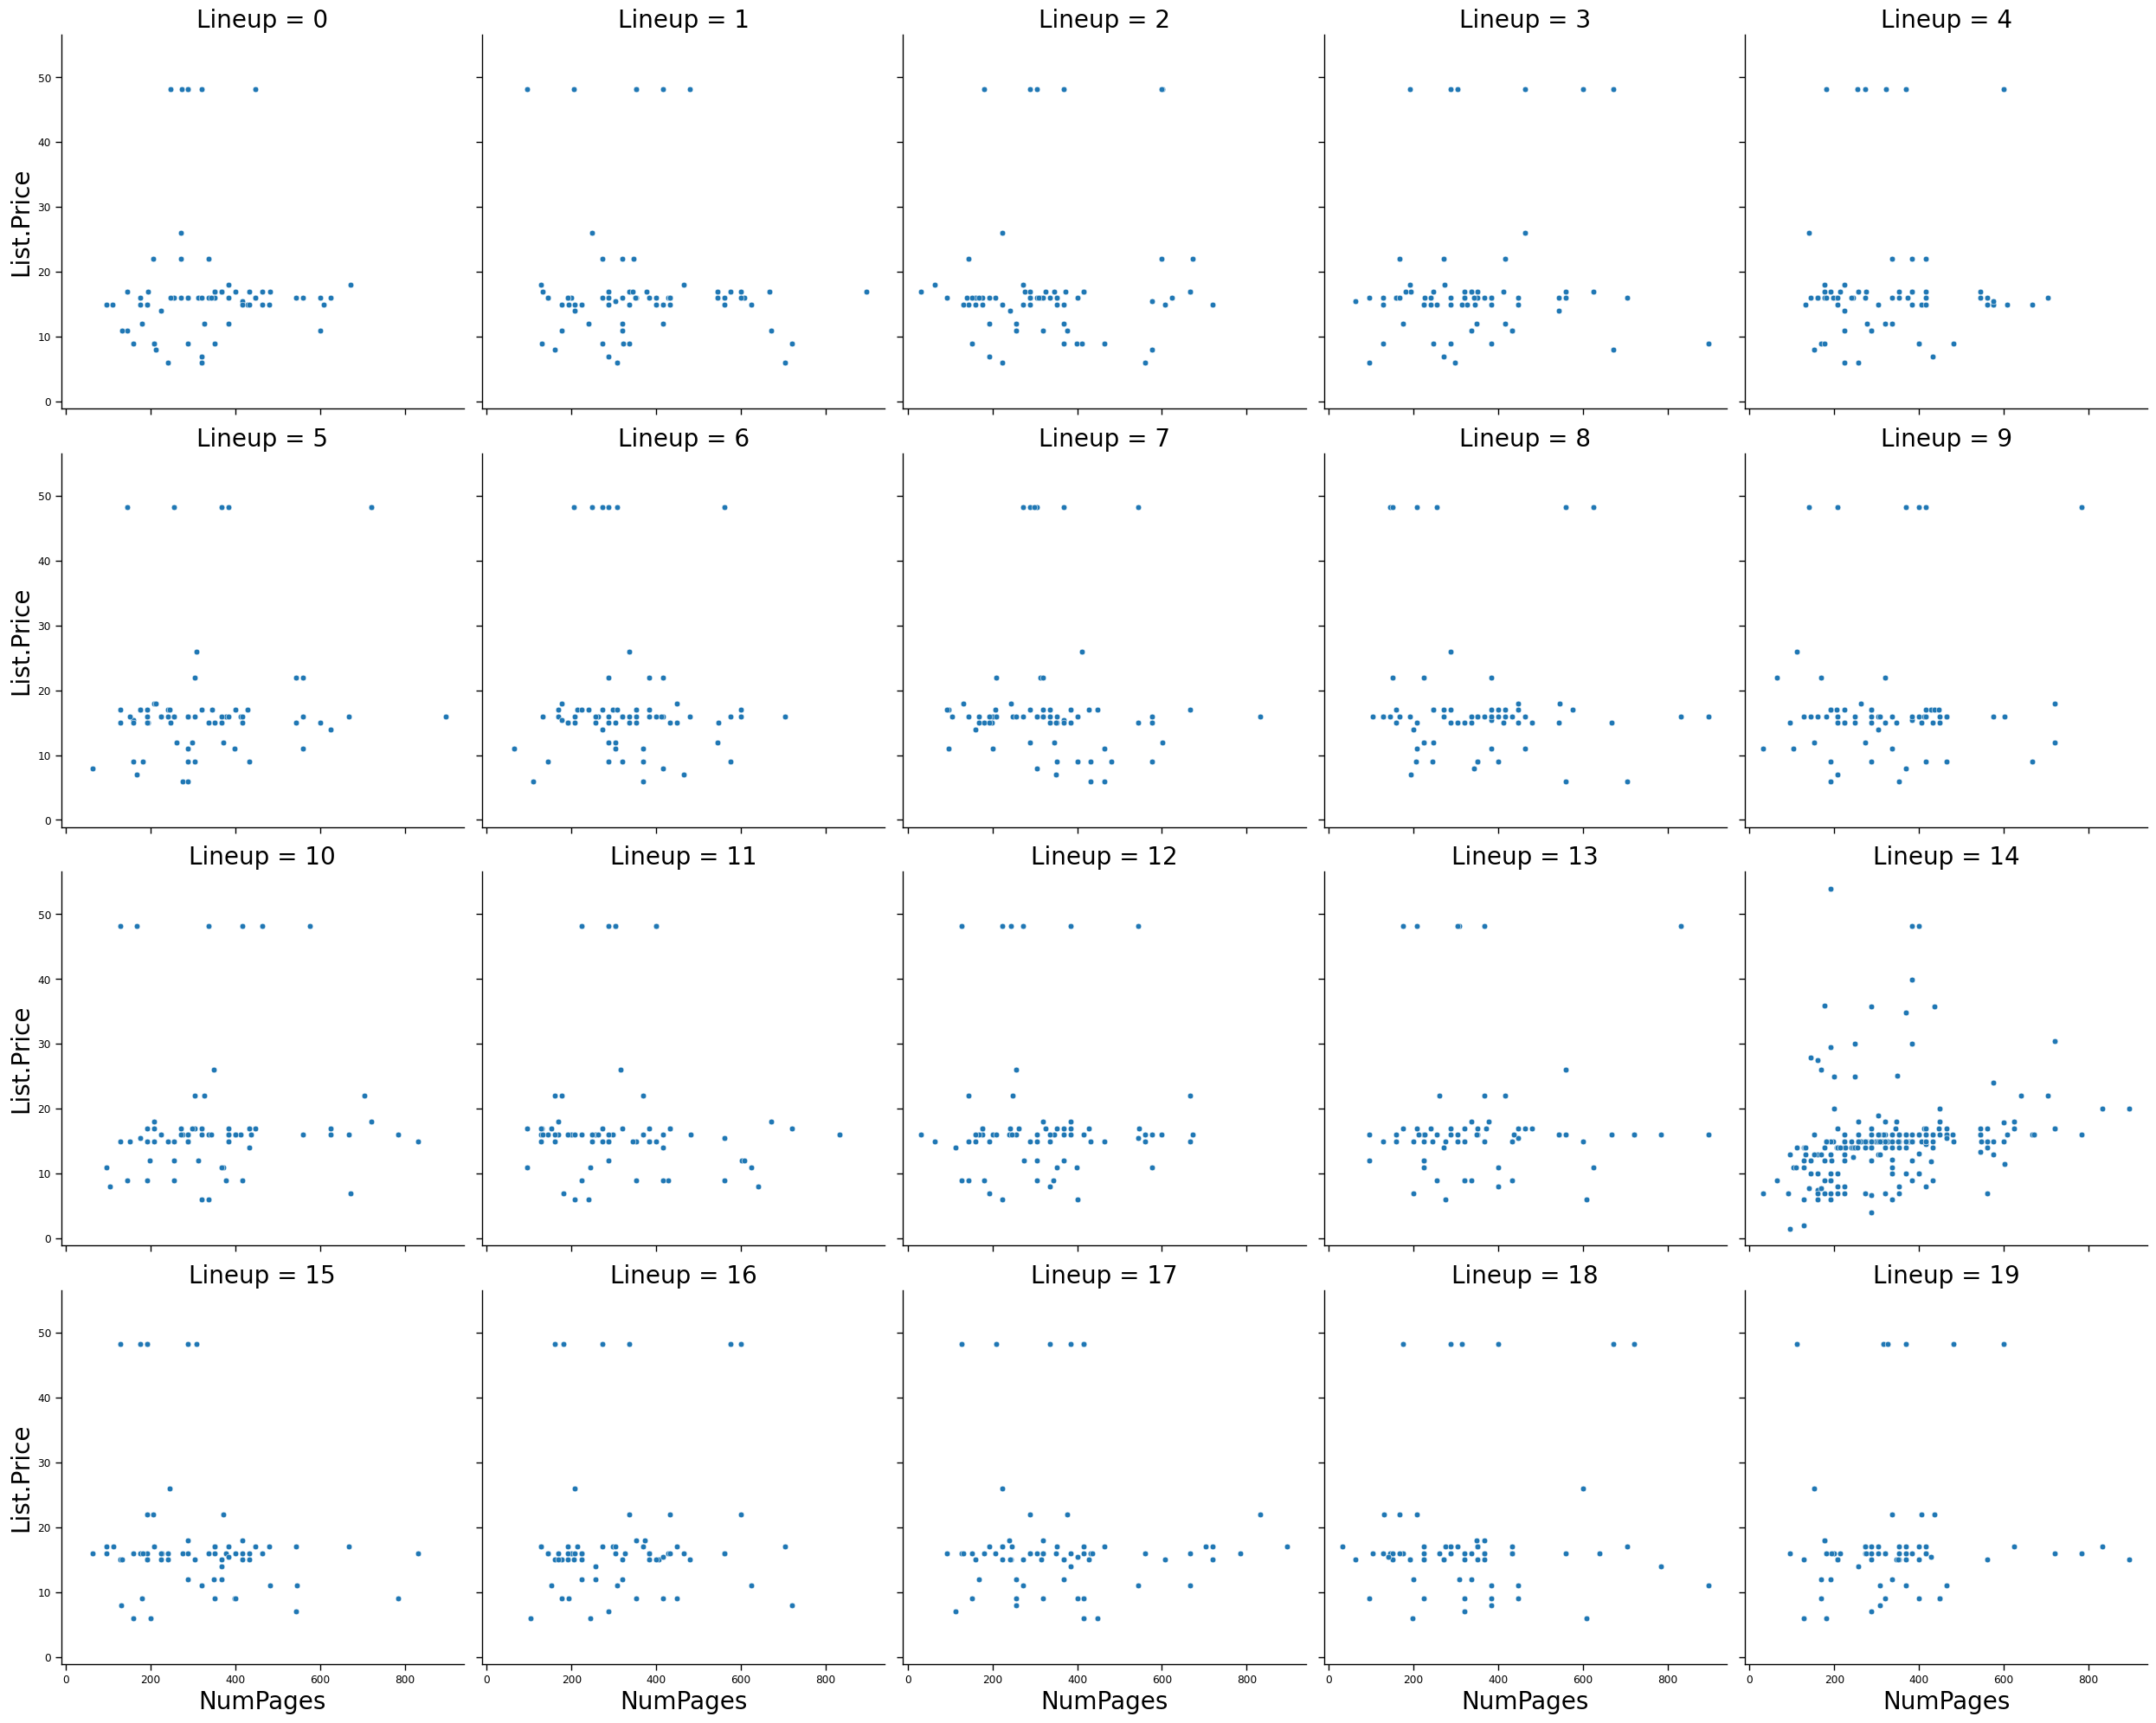

In [68]:
def create_lineup(the_data): 
    
    real_plot_num = np.random.permutation(range(20))[0]
    lineup_data = pd.DataFrame()
    
    for i in range(20):
        
        if i == real_plot_num:
            curr_data = the_data.copy()
        
        else:
            curr_data = pd.DataFrame(the_data.iloc[:, 1], the_data.iloc[:, 0]).reset_index()
            curr_data[curr_data.columns[1]] = np.random.permutation(curr_data[curr_data.columns[1]])
        
        curr_data.loc[:, "Lineup"] = i
        lineup_data = pd.concat([lineup_data, curr_data])
        
    lineup_data = lineup_data.reset_index()

    sns.set_context("paper", rc={"axes.labelsize":20})   
    sns.relplot(lineup_data, x = lineup_data.columns[1], y = lineup_data.columns[2], col = "Lineup", col_wrap=5); 

    return real_plot_num


the_answer = create_lineup(amazon_smaller)



In [69]:
# display the answer

# the_answer


## 5. Two-sided hypothesis test

Sometime in hypothesis testing we don't know the direction of an effect, we only know that the null hypothesis is incorrect. 

In these circumstances, we write our alternative hypothesis such that we state that the parameter value is not equal to the value specified by the null hypothesis.

For the baby weight example, we would write our hypotheses as:

$H_0$: $\mu_{non-smoke} =  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} = 0$ 

i.e., the null hypothesis is the same as before.

$H_A$: $\mu_{non-smoke} \ne  \mu_{smokes}$   or    $H_0$: $\mu_{non-smoke} -  \mu_{smokes} \ne 0$ 

We now use not equal to ($\ne$) in our alternative hypothesis.


To calculate the p-value, we need to look at the values more extreme than the observed statistic in in both tails. 



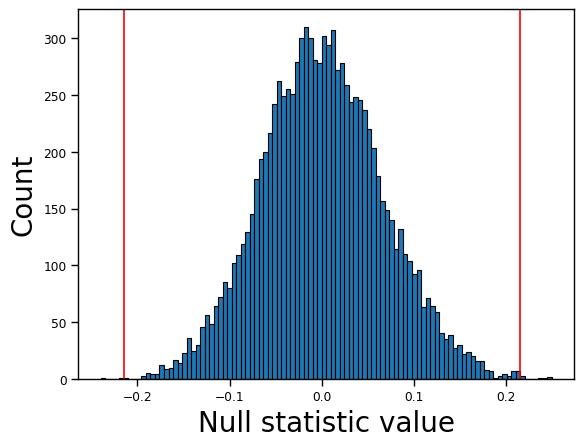

In [72]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put lines showing values more extreme than the observed statistic

plt.axvline(obs_stat, color = "red");
plt.axvline(-1 * obs_stat, color = "red");

plt.xlabel("Null statistic value");
plt.ylabel("Count");


When calculating the p-value, we need to get the proportion of statistics in the null distribution that are more extreme than the observed statistic from both tails.

In [71]:
p_value_right = np.mean(np.array(null_dist) >= obs_stat)
p_value_left = np.mean(np.array(null_dist) <= -1 * obs_stat)

p_value = p_value_right + p_value_left

p_value 


0.001